<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Introduction

The Cook County housing market is a complex ecosystem influenced by a myriad of factors. In this project, we delve into the realm of data science to analyze and understand this market better. Our journey begins with Exploratory Data Analysis (EDA), where we unravel the structure of the housing data to uncover patterns, trends, and anomalies.

With a thorough understanding of the data, we transition into the realm of predictive modeling. Leveraging the power of linear regression, we construct a model aimed at predicting housing prices based on various features. This model serves as a foundational tool for understanding the dynamics of the Cook County housing market and aids in making informed decisions.

However, the journey doesn't end here. We meticulously analyze the errors in our model, seeking opportunities for enhancement. Through iterative refinement and feature engineering, we strive to improve the model's performance, aiming for higher accuracy and predictive power.

Join us on this data-driven exploration of the Cook County housing market, where every insight gained brings us closer to unraveling its intricate dynamics.

In [1]:
""" 
For this project, we will utilize the numpy and pandas libraries for data manipulation, 
along with Matplotlib and Seaborn for data visualization.
"""
import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Data

The dataset consists of over 500,000 records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total. An explanation of each variable can be found in the included `CookCountyDataCodebook.txt` file .

The data are split into training and test sets with 204,792 and 68,264 observations, respectively, but we will only be working on the training set for this part of the project.

Let's first extract the data from the `cook_county_data.zip`. Just run the cells below: 

In [2]:
with zipfile.ZipFile('data/cook_county_data.zip') as item:
    item.extractall()

Now, let's load the training data.

In [3]:
training_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')

As a sanity check, we should verify that the data shape matches the description.

In [4]:
# 204792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values

The next order of business is getting a feel for the variables in our data.  A more detailed description of each variable is included in `CookCountyDataCodebook.txt` (in the same directory as this notebook). 

Let's take a quick look at all the current columns in our training data.

In [5]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Exploratory Data Analysis

This data set was collected by the [Cook County Assessor's Office](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) in order to build a model to predict the monetary value of a home . You can read more about data collection in the CCAO’s [Residential Data Integrity Preliminary Report](https://gitlab.com/ccao-data-science---modeling/ccao_sf_cama_dev/-/blob/master/documentation/Preliminary%20Report%20on%20Data%20Integrity%20June%207,%202019.pdf). In the later part of this project we will be building a linear model that predict sales prices using training data but it's important to first understand how the structure of the data informs such a model. In this section, we will make a series of exploratory visualizations and feature engineering in preparation for that prediction task.

### Sale Price
We begin by examining the distribution of our target variable `Sale Price`. We have created a helper method `plot_distribution` that one can use to visualize the distribution of the `Sale Price` using both the histogram and the box plot at the same time.

In [6]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

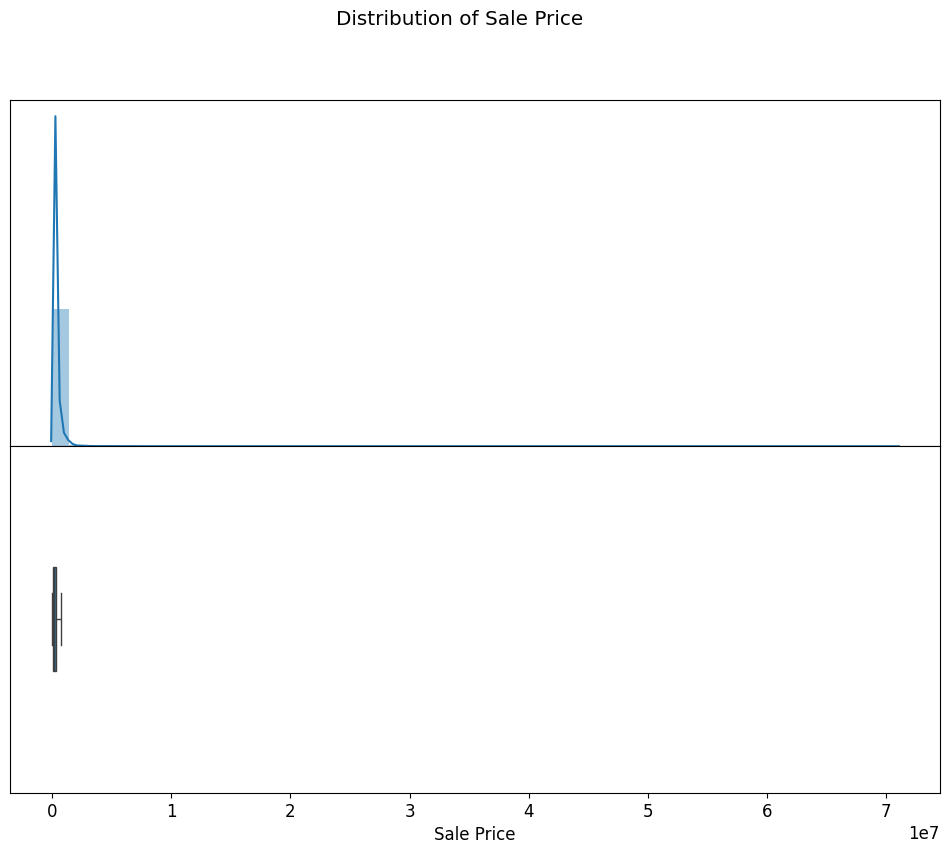

In [7]:
plot_distribution(training_data, label='Sale Price')

<br/>
<hr style="border: 1px solid #fdb515;" />

At the same time, we can also take a look at some descriptive statistics of the Sale Price.

In [8]:
training_data['Sale Price'].describe()

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

Taking a look at the distribution plot and the descriptive statistics, we can see a significant right skew cause by really large values in the sale price. To account for this It would be best to transform the sale price into the log of the sale price to decrease the range of sale prices to be smaller and on a similar order of magnitude.

<br/>
<hr style="border: 1px solid #fdb515;" />

To zoom in on the visualization of most households, we will focus only on a subset of `Sale Price` for this analysis. In addition, it would be a good idea to apply log transformation to `Sale Price`. In the cell below, we will reassign `training_data` to a new dataframe that is the same as the original one **except with the following changes**:

- `training_data` should contain only households whose price is at least $500.
- `training_data` should contain a new `Log Sale Price` column that contains the log-transformed sale prices.


**Note**: This also implies from now on, our target variable in the model will be the log-transformed sale prices from the column `Log Sale Price`. 

In [9]:
five_hundered_dollar_filter = training_data['Sale Price'] >= 500
training_data = training_data[five_hundered_dollar_filter]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])

Let's create a new distribution plot on the log-transformed sale price.


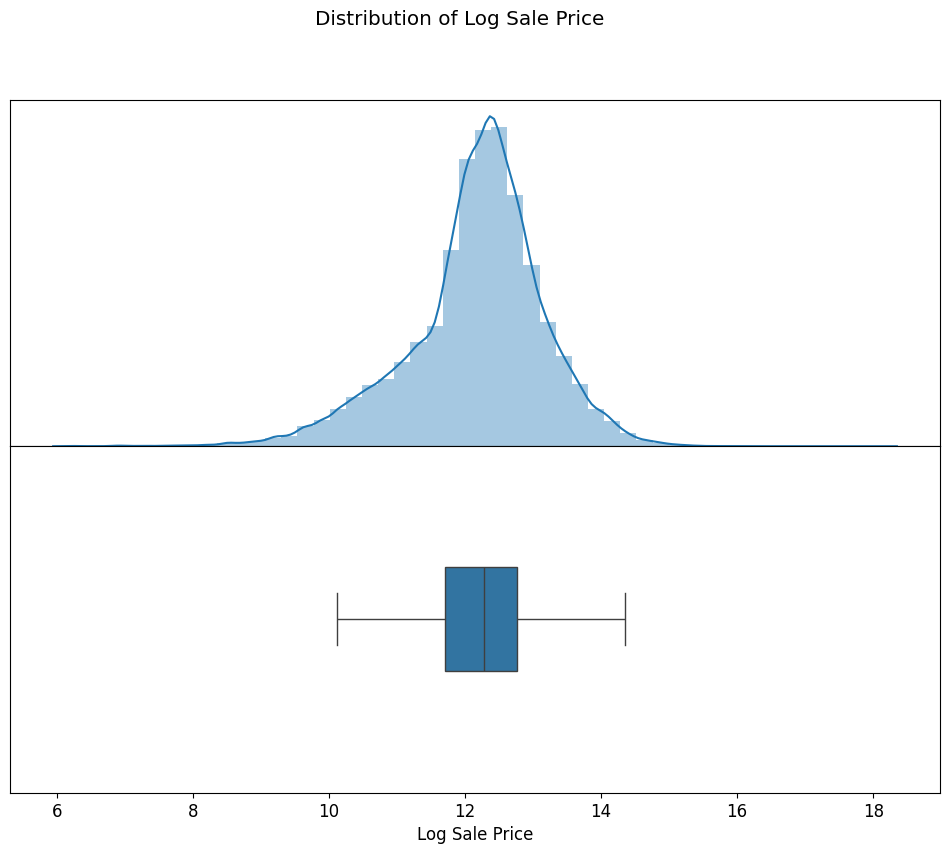

In [28]:
plot_distribution(training_data, 
                label='Log Sale Price')

<br/>
<hr style="border: 1px solid #fdb515;" />



A good question to get an idea of the price of homes is to ask whether it is true or false that at least 25% of the properties in the training set sold for more than $200,000.00. One way to check this is by using np.percentile for 75% and checking if it's greater than $200,000.

In [11]:
print(np.percentile(training_data['Sale Price'],75) > 200_000)

True


Next, we want to explore if there is any correlation between `Log Sale Price` and the total area occupied by the property. The `codebook.txt` file tells us the column `Building Square Feet` should do the trick -- it measures "(from the exterior) the total area, in square feet, occupied by the building".

Let's also apply a log transformation to the `Building Square Feet` column.

In [12]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

Now let's create a a `jointplot` with `Log Building Square Feet` on the x-axis, and `Log Sale Price` on the y-axis to see if `Log Building Square Feet` would make a good candidate as one of the features for our model.

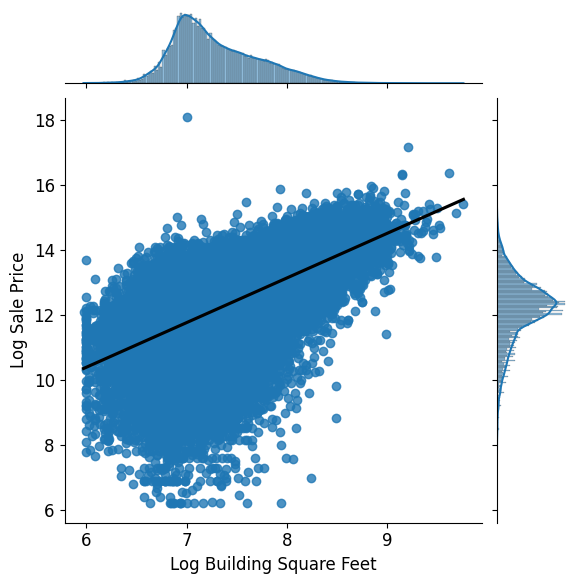

In [27]:
sns.jointplot(data=training_data, 
            x='Log Building Square Feet', 
            y='Log Sale Price', kind='reg', 
            joint_kws={'line_kws':{'color':'black'}})

The plot shows that the `Log Building Square Feet` would make a decent candidate as one of the features. Still, further transformations could be applied to 'linearize' the relationship between the two. They show potential because the residuals hover around 0 with values on both sides through the axis. This feature needs further work because the model tends to over-predict prices for smaller buildings and under-predict prices for larger structures.    

 As we explore the dataset further, we might still run into more outliers that prevent us from creating a clear visualization or capturing the trend of the majority of the houses. To address this issue we should create a function that will work to remove these outliers from the data as we run into them.

In [14]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
    data (data frame): the table to be filtered
    variable (string): the column with numerical outliers
    lower (numeric): observations with values lower than this will be removed
    upper (numeric): observations with values higher than this will be removed
    
    Output:
    a data frame with outliers removed
    
    Note: This function should not change mutate the contents of data.
    """  
    lower_filter = data[variable] >= lower
    upper_filter = data[variable] <= upper
    return data[lower_filter & upper_filter]

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Feature Engineering

### Bedrooms

Let's start simple by extracting the total number of bedrooms as our first feature for the model. You may notice that the `Bedrooms` column doesn't actually exist in the original `DataFrame`! Instead, it is part of the `Description` column.


---

Let's take a closer look at the `Description` column first.

In [15]:
# Print out Description column and notice where/how bathrooms are saved:
print(training_data["Description"][1])
print("")
print(training_data["Description"][60])

This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.

This property, sold on 10/11/2016, is a two-story houeshold located at 123 S LANCASTER AVE.It has a total of 9 rooms, 4 of which are bedrooms, and 2.5 of which are bathrooms.


Notice the number of bathrooms always shows up in the following statement "and x.y of which are bathrooms." 

Wait, why are these floating point numbers?  Here's how full versus half bathrooms are defined:
 - A full bathroom consists of four main elements — a sink, toilet, shower, and bathtub. 
 - A half-bath is a bathroom that contains two of the four elements, usually a sink and toilet, though in some cases a half-bath could just contain a shower and tub. 


To extract "x.y" as a float from the description column, we can use the following Regular Expression:


`bedrooms_regex = r'(\d) of which are bathrooms'`
 
 We can then use [str.extract](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.extract.html) to output this information:

 Now, let's write a function `add_total_bedrooms(data)` that returns a copy of `data` with an additional column called `Bedrooms` that contains the **total number of bedrooms (as integers)** for each house and treat missing values as zeros, if necessary.

In [16]:
def add_total_bedrooms(data):
    """
    Input:
    data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    rooms_regex = r'(\d) of which are bedrooms' 
    with_rooms['Bedrooms'] = data["Description"].str.extract(rooms_regex).astype(float)
    with_rooms.fillna(0,inplace = True)  # Treating missing values as zeros
    with_rooms['Bedrooms'] = with_rooms['Bedrooms'].astype(int)
    
    return with_rooms

training_data = add_total_bedrooms(training_data)


---

Now let's create a visualization that clearly and succinctly shows if there exists an association between  `Bedrooms` and `Log Sale Price`.

Text(0, 0.5, 'Log Sale Price')

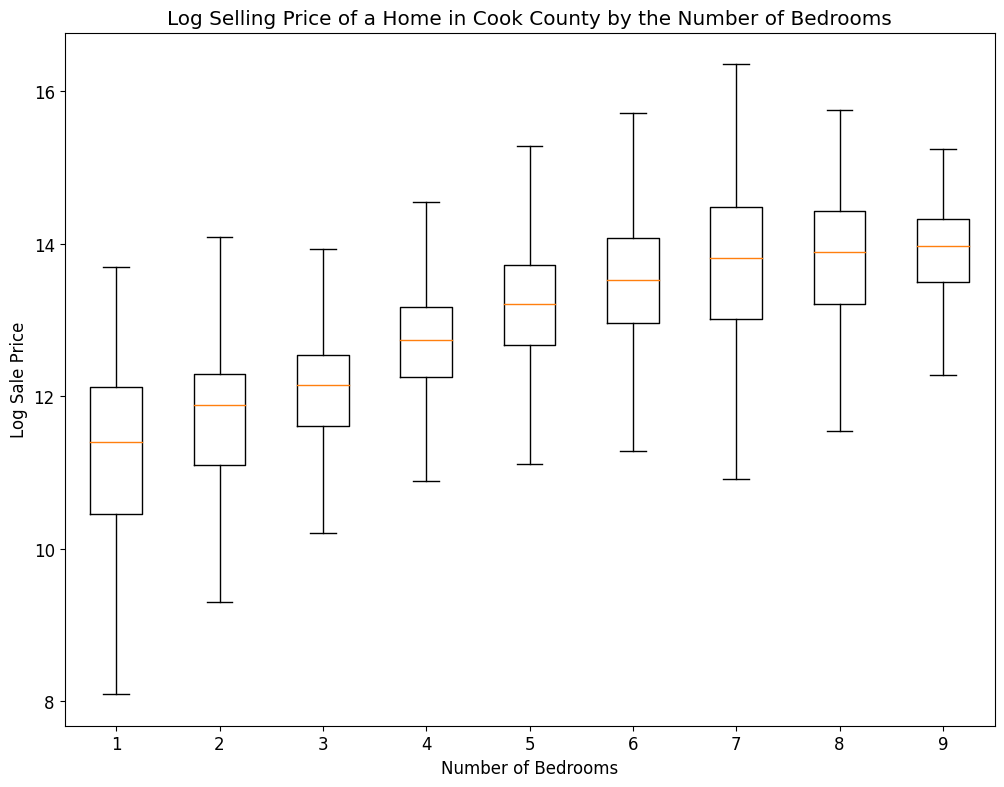

In [26]:
max_rooms_sold = training_data['Bedrooms'].max()
min_rooms_sold = 1
sale_price_list_by_bedroom_count = []
label_of_bedrooms = []

for i in range(min_rooms_sold,max_rooms_sold + 1):
    room_count_df = training_data[training_data['Bedrooms'] == i]
    sale_price_list_by_bedroom_count.append(room_count_df['Log Sale Price'])
    label_of_bedrooms.append(str(i) + ' Bedroom(s)')

plt.boxplot(x=sale_price_list_by_bedroom_count, 
            showfliers=False)
plt.title("Log Selling Price of a Home in Cook County by the Number of Bedrooms")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Log Sale Price")

---


Now, let's take a look at the relationship between neighborhood and sale prices of the houses in our dataset.
Notice that currently we don't have the actual names for the neighborhoods. Instead we will use a similar column `Neighborhood Code` (which is a numerical encoding of the actual neighborhoods by the Assessment office).

Before creating any visualization, let's quickly inspect how many different neighborhoods we are dealing with.

In [18]:
num_neighborhoods = training_data['Neighborhood Code'].nunique()
num_neighborhoods

193

---
If we try directly plotting the distribution of `Log Sale Price` for all of the households in each neighborhood using the `plot_categorical` function from the next cell, we would get the following visualization.

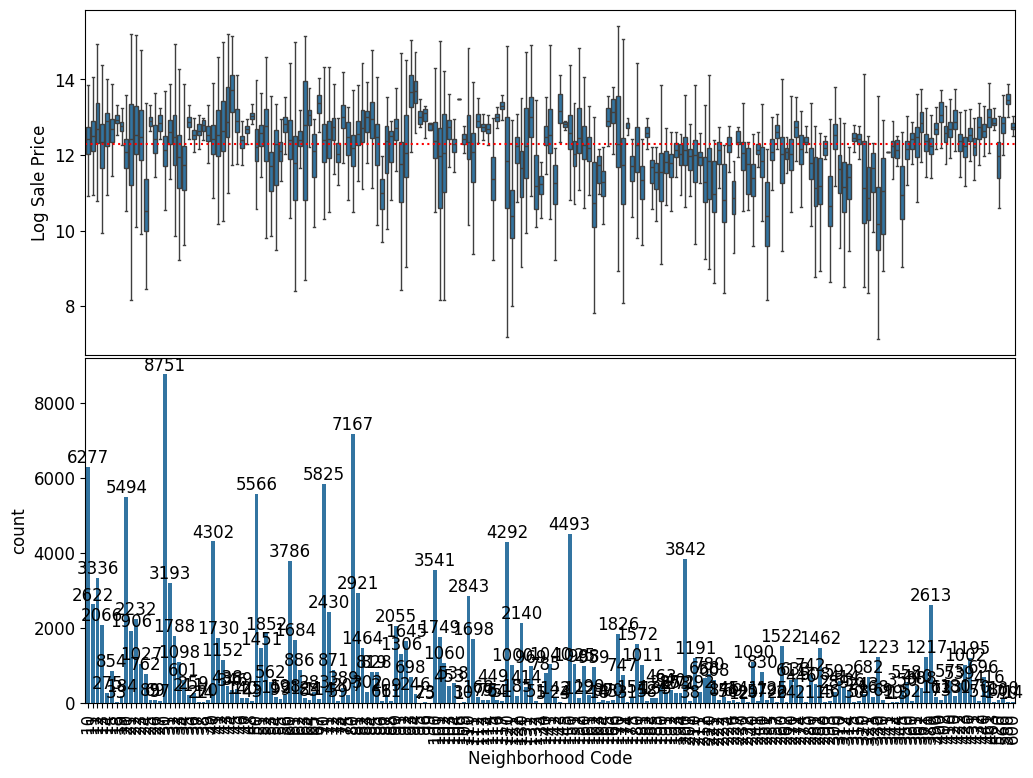

In [23]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
        showfliers=False
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)
plot_categorical(training_data)

It looks like we have a problem of overplotting! 

Noticing that the graph is overplotted because **there are actually quite a few neighborhoods in our dataset!** For the clarity of our visualization, we will have to zoom in again on a few of them. The reason for this is our visualization will become quite cluttered with a super dense x-axis.

To fix this let's assign the variable `in_top_20_neighborhoods` to a copy of `training_data` that has been filtered to only contain rows corresponding to properties that are in one of the top 20 most populous neighborhoods. We define the “top 20 neighborhoods” as being the 20 neighborhood codes that have the greatest number of properties within them.

In [24]:
# Make a copy of the df
in_top_20_neighborhoods = training_data.copy()

# Pull the 20 largest neighborhoods in our data and appending the codes to a list
top_20_neighborhoods = in_top_20_neighborhoods['Neighborhood Code'].value_counts()[:20].index.tolist()

# Filtering for data in the top 20 neighborhoods
in_top_20_neighborhoods = in_top_20_neighborhoods[in_top_20_neighborhoods['Neighborhood Code'].isin(top_20_neighborhoods)]

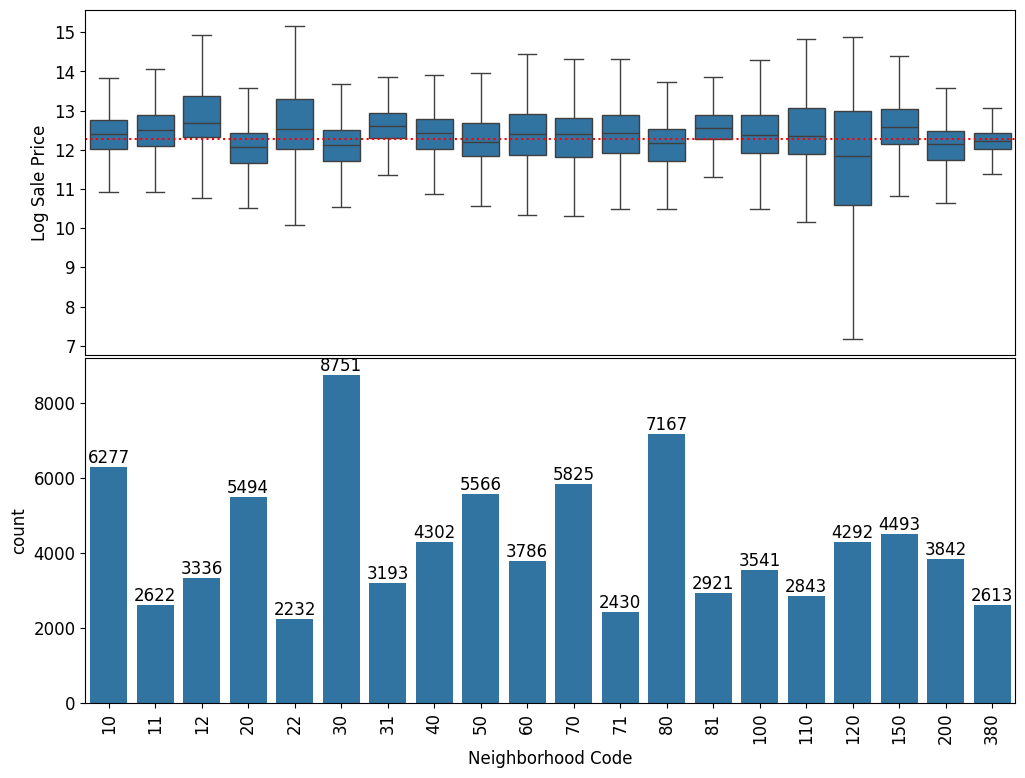

In [25]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

---

From the plot above, we can see that there is much less data available for some neighborhoods. For example, Neighborhood 71 has only around 27% of the number of datapoints as Neighborhood 30.

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together. We’ll categorize our neighborhoods in a crude way. We’ll compute how “expensive” each neighborhood is by aggregating the `Log Sale Price` for all properties in a particular neighborhood using a `metric`, such as the median. We’ll use this `metric` to find the top `n` most expensive neighborhoods. Then, we’ll label these “expensive neighborhoods” and leave all other neighborhoods unmarked.

We will make a new function `find_expensive_neighborhoods` to return a **list** of the neighborhood codes of the **top `n`** most expensive neighborhoods as measured by our choice of aggregating function, `metric`.

For example, calling `find_expensive_neighborhoods(training_data, n=3, metric=np.median)` should return the 3 neighborhood codes with the highest median `Log Sale Price` computed across all properties in those neighborhood codes. 


In [29]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
    data (data frame): should contain at least a string-valued 'Neighborhood Code'
        and a numeric 'Sale Price' column
    n (int): the number of top values desired
    metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
    a list of the the neighborhood codes of the top n highest-priced neighborhoods as measured by the metric function
    """
    
    # Make a copy
    neighborhoods = data.copy()
    
    # group by the code # and agg with the metric function on the Sale Price
    neighborhoods = neighborhoods.groupby('Neighborhood Code').agg({"Sale Price" : metric})
    
    # Sort the values
    neighborhoods = neighborhoods.sort_values("Sale Price", ascending = False)
    
    # Grab the top 3 code (index of the sort_by)
    neighborhoods = neighborhoods[0:n].index
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

---

We now have a list of neighborhoods we've deemed as higher-priced than others.  Let's use that information to write an additional function `add_expensive_neighborhood` that takes in a `DataFrame` of housing data (`data`) and a list of neighborhood codes considered to be expensive (`expensive_neighborhoods`). You can think of `expensive_neighborhoods` as being the output of the function `find_expensive_neighborhoods` from above. 

Using these inputs, `add_expensive_neighborhood` should add a column to `data` named `in_expensive_neighborhood` that takes on the **integer** value of 1 if a property is part of a neighborhood in `expensive_neighborhoods` and the integer value of 0 if it is not. This type of variable is known as an **indicator variable**.

In [30]:
def add_in_expensive_neighborhood(data, neighborhoods):
    """
    Input:
    data (data frame): a data frame containing a 'Neighborhood Code' column with values
        found in the codebook
    neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
    data frame identical to the input with the addition of a binary
    in_expensive_neighborhood column
    """
    # Check for expensive neighborhoods
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(neighborhoods) 
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

Now, we will take a closer look at the `Roof Material` feature of the dataset and examine how we can incorporate categorical features into the linear models we will be developing later on in the project.

---

If we look at `codebook.txt` carefully, we can see that the Assessor's Office uses the following mapping for the numerical values in the `Roof Material` column.
```
Roof Material (Nominal): 

       1    Shingle/Asphalt
       2    Tar & Gravel
       3    Slate
       4    Shake
       5    Tile
       6    Other
```

Let's write a function `substitute_roof_material` that replaces each numerical value in `Roof Material` with a `string` of the corresponding roof material. The function will return a new `DataFrame`, not modify the existing `DataFrame`.


In [33]:
def substitute_roof_material(data):
    """
    Input:
    data (data frame): a data frame containing a 'Roof Material' column.  Its values
        should be limited to those found in the codebook
    Output:
    data frame identical to the input except with a refactored 'Roof Material' column
    """
    modified_data = data.copy()
    modified_data['Roof Material'] = modified_data['Roof Material'].replace([1,2,3,4,5,6],['Shingle/Asphalt','Tar&Gravel','Slate','Shake','Tile','Other'])
    return modified_data
    
training_data = substitute_roof_material(training_data)

---

#### One Hot Encoding 

Unfortunately, simply fixing these missing values isn't sufficient for using `Roof Material` in our model.  Since `Roof Material` is a categorical variable, we will have to one-hot-encode the data.  Notice in the example code below that we have to pre-specify the categories. 
 - For more information on why we want to use one-hot-encoding, refer to this [link](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).

Complete the following function `ohe_roof_material` that returns a copy of the original dataframe with the new column one-hot-encoded on the roof material of the household. These new columns should have the form `Roof Material_MATERIAL`.  In this problem we only wish to construct the one-hot-encoding columns **without removing any columns**. Your function should return **a new DataFrame, not modify the existing DataFrame.**  

**Note**: You should **avoid using `pd.get_dummies`** in your solution as it will remove your original column and is therefore not as reusable as your constructed data preprocessing pipeline. Instead, you can one-hot-encode one column into multiple columns **using Scikit-learn's [One Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)**. It's far more customizable! 

In [36]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material.  New columns are of the form "Roof Material_MATERIAL"
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Roof Material']]);
    new_df = pd.DataFrame(oh_enc.transform(data[['Roof Material']]).todense(), columns = oh_enc.get_feature_names_out(), index = data.index)
    return  pd.concat([data, new_df],axis=1)
training_data_ohe = ohe_roof_material(training_data)
#This line of code will display only the one-hot-encoded columns in training_data_ohe that 
# have names that begin with “Roof Material_" 
training_data_ohe.filter(regex='^Roof Material_').head(5)

,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar&Gravel,Roof Material_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
